# Check the GPU

In [ ]:
!nvidia-smi

Sat Jul 18 12:19:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0" 

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 42.3MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
# used during model training to save the model, change learning rate, reduce lr
from fastai.callbacks.hooks import *

In [ ]:
arch = models.resnet50

img_size = 224

In [ ]:
# Downloading the dataset from the website
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# Unzipping the dataset into Google Drive Storage
# !tar xzvf '/content/drive/My Drive/Colab Notebooks/food-101/food-101.tar.gz' -C '/content/drive/My Drive/Colab Notebooks/food-101/'

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/food-101/food-101') 
path_img = path/'images'


In [ ]:
torch.__version__

'1.4.0'

In [ ]:
train_path = path/'meta/train.txt'
test_path = path/'meta/test.txt'

# function to convert csv file to dataframe
def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

# use fastai to write the transformation/augmentation function
# This works like crop but if the target size is bigger than the size of the image (on either dimension), padding is applied according to padding_mode (see pad for an example of all the options) and the position of center is ignored on that dimension.
# data_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
data_tfms = ([RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            # Added Warp and Jitter. Changing probability  from p=0.75 to 0.3 improved training time from 6 hrs to 2hrs
            # Was hoping to get more accuracy by adding these, albeit at the cost of higher run time
            # This database appeared to have reasonably clear pictures, not too much jitter or noise.
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.3, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.4, resolved={}, do_run=True, is_random=True), 
            # Tried using perspective_warp, but need to study more and implement a value for magnitude
            # RandTransform(tfm=TfmCoord (perspective_warp), kwargs={'magnitude': (-0.01, 0.01)}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmPixel (cutout), kwargs={}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.7, resolved={}, do_run=True, is_random=True), 
            # Varied this from 1.2 to 1.3 to improve accuracy and p=0.75 to 0.7 to improve time
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.2)}, p=0.7, resolved={}, do_run=True, is_random=True), 
            # RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True)],
            # Changed this after 10 epochs and retrained with crop_pad above
            RandTransform(tfm=TfmPixel (crop), kwargs={'size':224, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True)], 
            # Changed this after 18 epochs and retrained with crop above
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])



bs =128
# data_tfms = get_transforms(do_flip:bool=True, flip_vert:bool=True, 
#                max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, 
#                max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, 
#                xtra_tfms:Optional[Collection[Transform]]=None) 

#  data_tfms = (get_transforms)
# read the list of train/test image names from the dataframe and provide the path to the images itself
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(data_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


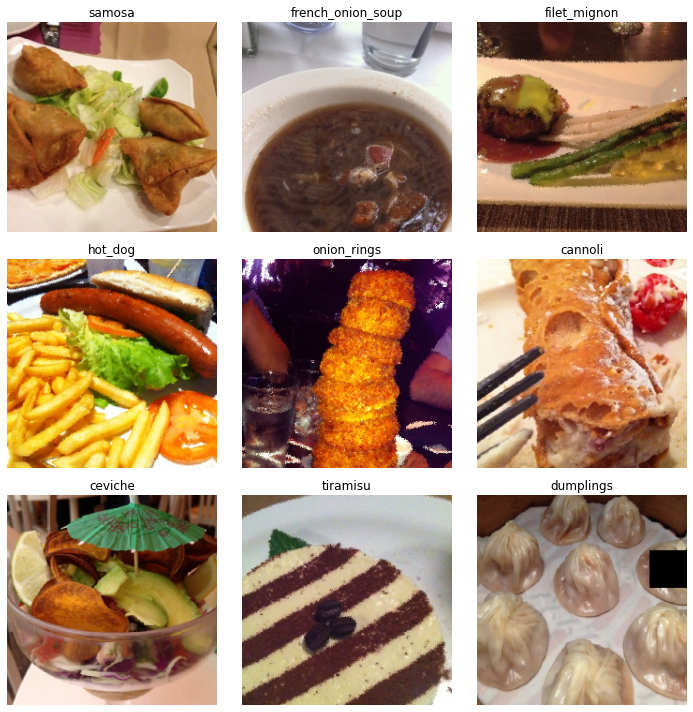

In [ ]:
data.show_batch(rows=3, figsize=(10, 10))

In [ ]:
print(data.classes);
print(data.c)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
top_5 = partial(top_k_accuracy, k=5)

learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 5.75E-03


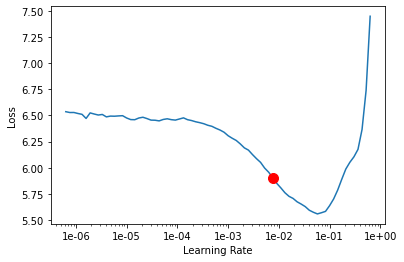

In [ ]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.224796,9.942251,0.387393,0.678878,6:03:58
1,1.739245,3.670944,0.632805,0.863432,20:53


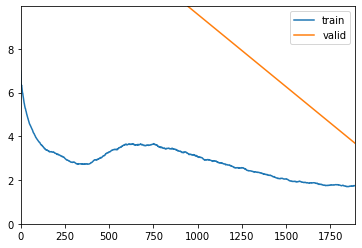

In [ ]:
lr = 5.25E-02
# learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e2')
learn.fit_one_cycle(2, slice(lr))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e2')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.964825,15.176827,0.462706,0.745017,2:23:47
1,1.595929,9.637825,0.657162,0.873663,26:55


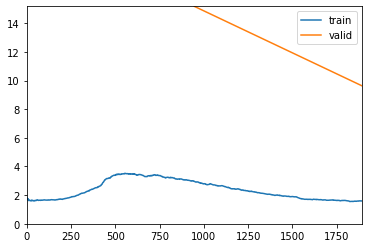

In [ ]:
lr = 5.25E-02
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e2')
learn.fit_one_cycle(2, slice(lr))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e4')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.027400,16.004694,0.470561,0.743696,26:37
1,2.863873,21.831820,0.509835,0.788713,26:23
2,1.828753,22.587776,0.625017,0.859538,26:00
3,1.406966,9.335968,0.687723,0.888845,26:33


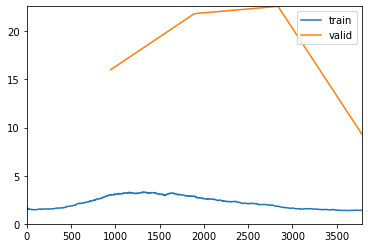

In [ ]:
lr = 5.25E-02
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e4')
learn.fit_one_cycle(4, slice(lr))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e10')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.684884,9.377541,0.639934,0.871221,26:16
1,2.904092,7.371217,0.489703,0.758944,26:30
2,2.987166,32.380520,0.432277,0.701386,25:42
3,2.621192,59.553471,0.528515,0.784026,26:47


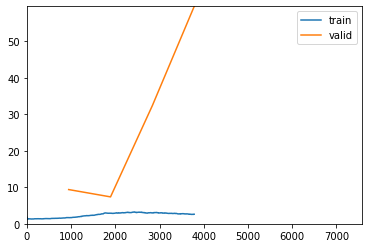

In [ ]:
lr = 5.25E-02
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-e10')
learn.fit_one_cycle(8, slice(lr))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-test-18')